In [1]:
from helpers.alibaba import inject_billed_alibaba, load_all_billed_alibaba
from helpers.aws import inject_billed_aws, load_all_billed_aws
from helpers.azure import inject_billed_azure, load_all_billed_azure
from helpers.benchmark import load_records_from_directory, filter_full_lifecycle, trim_on_benchmark
import pandas as pd

from helpers.gcp import inject_billed_gcp, load_all_billed_gcp

# === Stage B Data Loading ===

LOG_DIR = "data/stage_b"
df_raw = load_records_from_directory(LOG_DIR)
df = filter_full_lifecycle(df_raw, remove_cold=True)


billed_alibaba_df = load_all_billed_alibaba(f"{LOG_DIR}/billed/alibaba")
df = inject_billed_alibaba(df, billed_alibaba_df)

billed_azure_df = load_all_billed_azure(f"{LOG_DIR}/billed/azure")
df = inject_billed_azure(df, billed_azure_df)

billed_gcp_df = load_all_billed_gcp(f"{LOG_DIR}/billed/gcp")
df = inject_billed_gcp(df, billed_gcp_df)

billed_aws_df = load_all_billed_aws(f"{LOG_DIR}/billed/aws")
df = inject_billed_aws(df, billed_aws_df)


# Stage B configs: provider -> list of memory sizes
STAGE_B_CONFIGS = [
    ("aws", [128, 512, 2048]),
    ("gcp", [128, 512, 2048]),
    ("alibaba", [128, 512, 2048]),
    ("azure", [512, 2048]),  # Azure has no 128MB tier
]


allowed = {(p, m) for (p, mems) in STAGE_B_CONFIGS for m in mems}
df = df[df.apply(lambda r: (r["provider"], r["memory_size_mb"]) in allowed, axis=1)].copy()


trimmed_df  = pd.DataFrame()
for provider, mem_sizes in STAGE_B_CONFIGS:
    for mem_size in mem_sizes:
        df_subset = df[
            (df["provider"] == provider)
            & (df["memory_size_mb"] == mem_size)
        ]
        
        df_subset = trim_on_benchmark(df_subset, group_on_timestamp=False, benchmark="gemm")
        trimmed_df = pd.concat([trimmed_df, df_subset], ignore_index=True)



print("raw rows:", len(df_raw))
print("filtered rows:", len(df))


# Check what we got
print("\nRecords per provider/memory:")
print(df.groupby(["provider", "memory_size_mb"]).size().unstack(fill_value=0))
print("\nTrimmed records per provider/memory:")
print(trimmed_df.groupby(["provider", "memory_size_mb"]).size().unstack(fill_value=0))

📥 Loaded 52204 billed Alibaba records from 1 files.
✅ All Alibaba entries matched billed durations.
📥 Loaded 38583 billed Azure records from 1 files.
✅ All Azure entries matched billed durations.
📥 Loaded 54000 billed GCP records from 6 files.
✅ All GCP entries matched billed durations.
📥 Loaded 54000 billed AWS records from 6 files.
✅ All AWS entries matched billed durations.
raw rows: 195834
filtered rows: 122670

Records per provider/memory:
memory_size_mb  128    512    2048
provider                          
alibaba         9666  11334  11844
aws             9936  11061  11646
azure              0  11691  11820
gcp             9444  11370  12858

Trimmed records per provider/memory:
memory_size_mb  128    512    2048
provider                          
alibaba         9568  11219  11724
aws             9834  10948  11528
azure              0  11573  11701
gcp             9348  11253  12726


In [2]:
import numpy as np

for provider in ["aws", "azure", "gcp", "alibaba"]:
    provider_df = df[df["provider"] == provider].copy()
    
    # Convert flags to a sortable string representation
    provider_df["flags_str"] = provider_df["flags"].apply(
        lambda x: " ".join(sorted(x)) if isinstance(x, (list, np.ndarray)) else str(x)
    )
    
    print(f"\n{'='*60}")
    print(f"Provider: {provider.upper()}")
    print(f"{'='*60}")
    
    for cpu in sorted(provider_df["cpu_type"].unique()):
        cpu_flags = provider_df[provider_df["cpu_type"] == cpu]["flags_str"].unique()
        print(f"\n  CPU: {cpu}")
        print(f"  Unique flag sets: {len(cpu_flags)}")
        for i, flags in enumerate(cpu_flags, start=1):
            print(f"    {i}. {flags}")


Provider: AWS

  CPU: AMD EPYC 2.25GHz
  Unique flag sets: 1
    1. 3dnowprefetch abm aes apic arat avx avx2 bmi1 bmi2 clflush cmov cmp_legacy constant_tsc cpuid cr8_legacy cx16 cx8 de erms f16c fma fpu fsgsbase fxsr ht hypervisor ibpb ibrs invpcid invpcid_single lahf_lm lm mca mce mmx movbe msr mtrr nonstop_tsc nopl nx osvw pae pat pcid pclmulqdq perfctr_core pge pni popcnt pse pse36 rdrand rdtscp sep smap smep ssbd sse sse2 sse4_1 sse4_2 ssse3 stibp syscall topoext tsc tsc_adjust tsc_deadline_timer tsc_known_freq vme vmmcall x2apic xsave xsaveerptr xsaveopt

  CPU: AMD EPYC 2.65GHz
  Unique flag sets: 1
    1. 3dnowprefetch abm aes apic arat avx avx2 bmi1 bmi2 clflush cmov cmp_legacy constant_tsc cpuid cr8_legacy cx16 cx8 de erms f16c fma fpu fsgsbase fxsr ht hypervisor ibpb ibrs invpcid invpcid_single lahf_lm lm mca mce mmx movbe msr mtrr nonstop_tsc nopl nx osvw pae pat pcid pclmulqdq perfctr_core pge pni popcnt pse pse36 rdrand rdtscp sep smap smep ssbd sse sse2 sse4_1 sse4_2 sss

💾 Saved to: plots/stage_b/ecdf_aws_by_memory.pdf


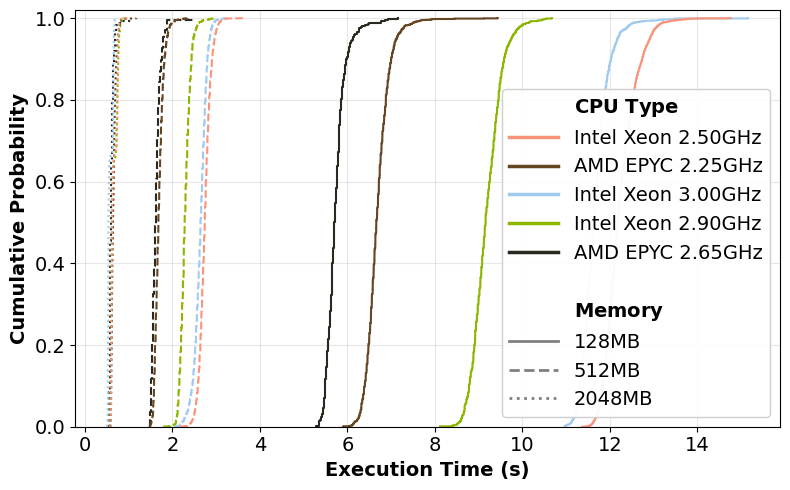

💾 Saved to: plots/stage_b/ecdf_gcp_by_memory.pdf


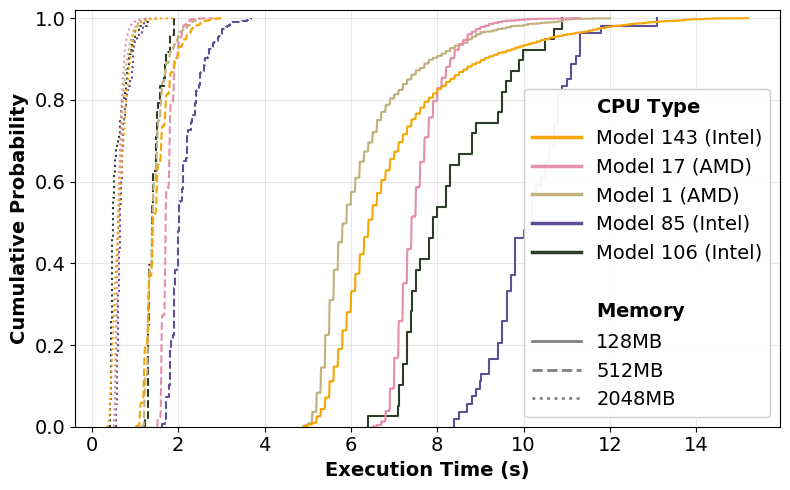

💾 Saved to: plots/stage_b/ecdf_alibaba_by_memory.pdf


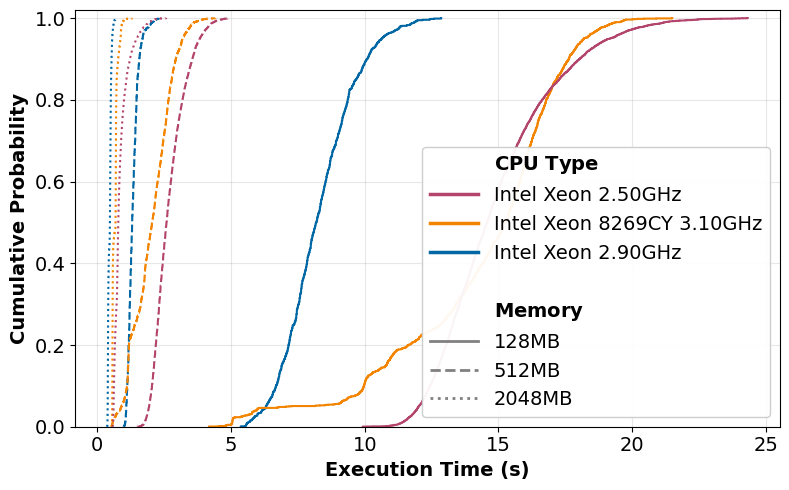

💾 Saved to: plots/stage_b/ecdf_azure_by_memory.pdf


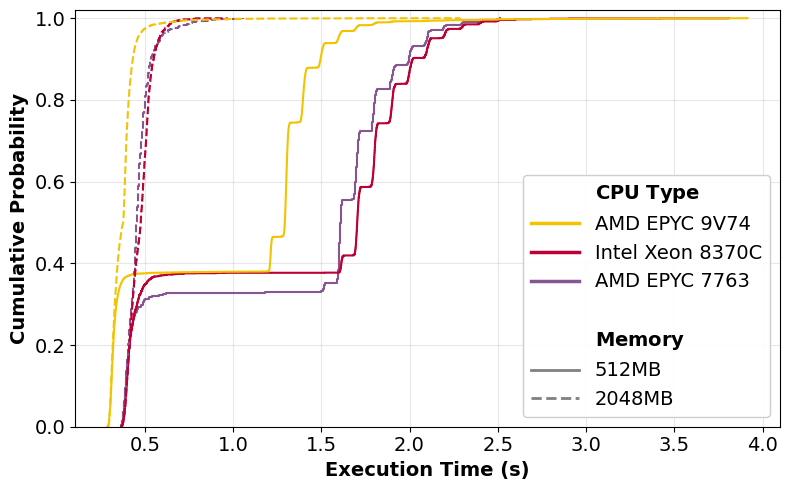

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_color


def plot_ecdf_by_memory(
    df: pd.DataFrame,
    provider: str,
    memory_configs: list[int] | None = None,
    save_path: str | None = None,
    show: bool = True,
):

    provider_df = df[
        (df["provider"] == provider) &
        (df["benchmark_type"] == "gemm") &
        (df["memory_size_mb"].isin(memory_configs))
    ].copy()
    
    if provider_df.empty:
        print(f"No data found for {provider} - {"gemm"}")
        return None
    
    provider_df["cpu_short"] = provider_df["cpu_type"].apply(shorten_cpu_name)
    
    cpu_order = (
        provider_df.groupby("cpu_short")
        .size()
        .sort_values(ascending=False)
        .index.tolist()
    )
    
    palette = {
        shorten_cpu_name(cpu): get_cpu_color(cpu, provider) 
        for cpu in provider_df["cpu_type"].unique()
    }
    
    line_styles = ["-", "--", ":", "-."]
    style_map = {
        mem: line_styles[i % len(line_styles)] 
        for i, mem in enumerate(memory_configs)
    }
    
    metric_field = metric_for_benchmark("gemm")
    fig, ax = plt.subplots(figsize=(8, 5))

    provider_df[metric_field] = provider_df[metric_field] / 1000.0  # Convert ms to s
    
    # Plot each memory config with different line styles
    for mem in memory_configs:
        mem_subset = provider_df[provider_df["memory_size_mb"] == mem]
        
        if mem_subset.empty:
            continue
            
        sns.ecdfplot(
            data=mem_subset,
            x=metric_field,
            hue="cpu_short",
            hue_order=cpu_order,
            palette=palette,
            linestyle=style_map[mem],
            linewidth=1.5,
            ax=ax,
            legend=False
        )
    
    ax.set_xlabel("Execution Time (s)", fontsize=14, fontweight="bold")
    ax.set_ylabel("Cumulative Probability", fontsize=14, fontweight="bold")
    ax.tick_params(axis="both", which="major", labelsize=14)
    

    
    legend_elements = []
    
    legend_elements.append(Line2D([0], [0], color="none", label="$\\bf{CPU\\ Type}$"))
    for cpu_short in cpu_order:
        legend_elements.append(
            Line2D([0], [0], color=palette[cpu_short], linewidth=2.5, label=cpu_short)
        )
    
    legend_elements.append(Line2D([0], [0], color="none", label=""))
    
    legend_elements.append(Line2D([0], [0], color="none", label="$\\bf{Memory}$"))
    for mem in memory_configs:
        legend_elements.append(
            Line2D([0], [0], color="gray", linestyle=style_map[mem], 
                   linewidth=2, label=f"{mem}MB")
        )
    
    ax.legend(
        handles=legend_elements, 
        loc="lower right", 
        framealpha=0.95, 
        fontsize=14, 
        handlelength=2.5
    )
    
    ax.set_ylim(0, 1.02)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"💾 Saved to: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    return fig


for provider, mem_sizes in STAGE_B_CONFIGS:
    plot_ecdf_by_memory(
        df,
        provider=provider,
        memory_configs=mem_sizes,
        save_path=f"plots/stage_b/ecdf_{provider}_by_memory.pdf",
        show=True,
    )

                                        uuid  new_container  invocation_count
19641   bf0bcc8f-3048-400d-b45a-21a839d44336              0                 2
19663   358d7548-1f01-4b2f-b871-8d02d2e94c05              0                 2
19677   83ba31f5-75fd-41ba-9689-c19a7385d988              0                 2
19678   f06582a0-6511-49f2-b5d5-6652bbfdc459              0                 2
19680   25d4d51e-5b29-4ebb-a98c-38b267851c97              0                 2
...                                      ...            ...               ...
195775  341287eb-8e11-4fa3-b126-7125fd22de54              0                 4
195784  71e4225e-fb7f-4317-8f2e-46baef9d810e              0                 4
195810  858e7c4e-4c04-48fc-9108-ab293d3cf4ab              0                 4
195816  63aaa424-a263-4c16-a0a7-3b2705dd7c78              0                 4
195833  f10b3814-f753-41b3-b572-26f91f3ea6ea              0                 4

[9936 rows x 3 columns]
Plotting aws with 128MB: 9936 records


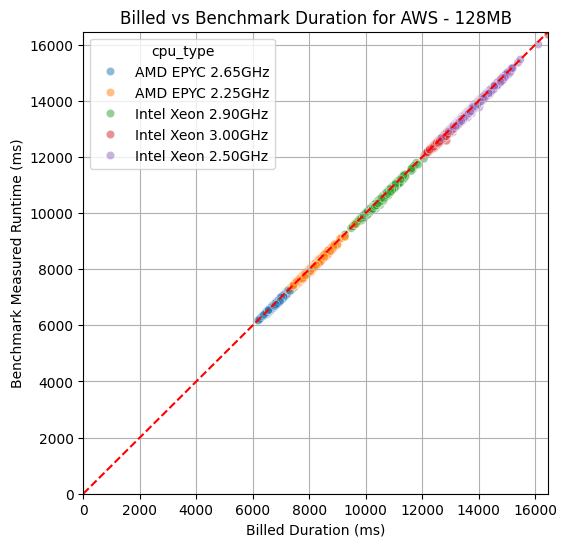

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_billed_vs_benchmark(provider, memory_size_mb):
    subset = df[(df["provider"] == provider) & (df["memory_size_mb"] == memory_size_mb) & (df["billed_duration_ms"].notnull())]

    # print id of records that have no new container but invocation count 1
    no_new_container = subset[(subset["new_container"] == 0)]
    print(no_new_container[["uuid", "new_container", "invocation_count"]])

    print(f"Plotting {provider} with {memory_size_mb}MB: {len(subset)} records")
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        data=subset,
        x="billed_duration_ms",
        y="runtime_ms",
        hue="cpu_type",
        alpha=0.5,
    )

    max_val = max(subset["billed_duration_ms"].max(), subset["runtime_ms"].max())
    plt.plot([0, max_val], [0, max_val], color="red", linestyle="--")
    plt.title(f"Billed vs Benchmark Duration for {provider.upper()} - {memory_size_mb}MB")
    plt.xlabel("Billed Duration (ms)")
    plt.ylabel("Benchmark Measured Runtime (ms)")
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.grid(True)
    plt.show()

# Example usage:
plot_billed_vs_benchmark("aws", 128)

Saved: plots/stage_b/cpu_composition.pdf


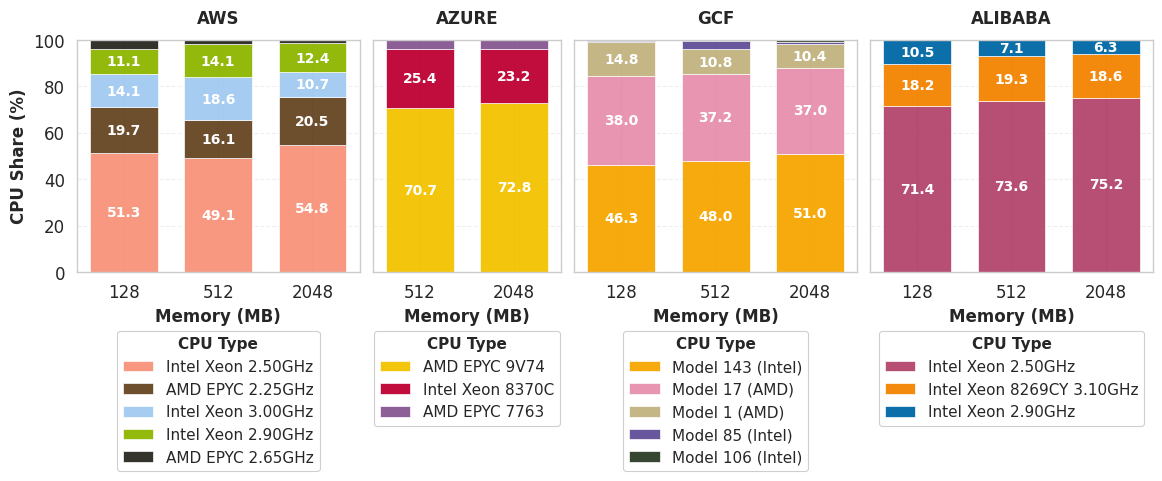

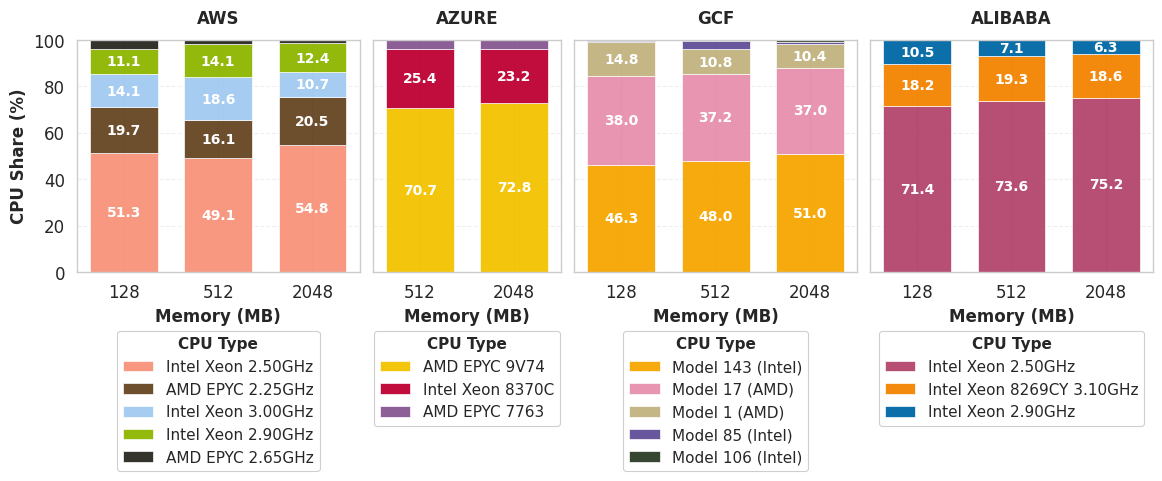

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from helpers.cpus import shorten_cpu_name, get_cpu_color

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def plot_stage_b_cpu_composition(
    df: pd.DataFrame,
    save_path: str | None = None,
    show: bool = True,
):
    """
    Stage B: CPU share across providers and memory configurations (GEMM only).

    4 subplots (one per provider), stacked bars per memory size.
    Uses standard rectangles (ax.bar) so stacked segments look consistent.
    """
    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]

    # -------------------------
    # Build long-form shares
    # -------------------------
    rows = []
    for provider in providers:
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes

        for mem in provider_memory_sizes:
            sub = df[
                (df["provider"] == provider)
                & (df["memory_size_mb"] == mem)
                & (df["benchmark_type"] == "gemm")
            ].copy()

            if sub.empty:
                continue

            cpu_counts = sub["cpu_type"].value_counts(dropna=True)
            total = int(cpu_counts.sum())
            if total <= 0:
                continue

            for cpu, count in cpu_counts.items():
                rows.append(
                    {
                        "provider": provider,
                        "memory_size": mem,
                        "cpu_type": cpu,
                        "percentage": (count / total) * 100.0,
                    }
                )

    results_df = pd.DataFrame(rows)
    if results_df.empty:
        raise ValueError("No data found after filtering (provider/memory/gemm).")

    # -------------------------
    # Figure layout
    # -------------------------
    fig, axes = plt.subplots(
        1, 4,
        figsize=(12, 4),
        sharey=True,
        gridspec_kw={"width_ratios": [3, 2, 3, 3]},
    )

    bar_width = 0.72

    for idx, provider in enumerate(providers):
        ax = axes[idx]
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes
        pdata = results_df[results_df["provider"] == provider].copy()

        x = np.arange(len(provider_memory_sizes))

        if pdata.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes, fontsize=12)
            ax.set_xticks(x)
            ax.set_xticklabels([f"{m}MB" for m in provider_memory_sizes], fontsize=10)
            ax.set_title(provider.upper(), fontweight="bold", fontsize=11, pad=12)
            ax.set_xlim(-0.5, len(provider_memory_sizes) - 0.5)
            ax.margins(x=0)
            continue

        # CPU order per provider by total share (desc)
        cpu_order = (
            pdata.groupby("cpu_type")["percentage"]
            .sum()
            .sort_values(ascending=False)
            .index.tolist()
        )

        wide = (
            pdata.pivot_table(
                index="memory_size",
                columns="cpu_type",
                values="percentage",
                aggfunc="sum",
                fill_value=0.0,
            )
            .reindex(index=provider_memory_sizes, fill_value=0.0)
            .reindex(columns=cpu_order, fill_value=0.0)
        )

        bottom = np.zeros(len(provider_memory_sizes))

        legend_handles = []
        legend_labels = []

        for cpu in cpu_order:
            vals = wide[cpu].to_numpy(dtype=float)
            color = get_cpu_color(cpu, provider=provider)

            bars = ax.bar(
                x,
                vals,
                bottom=bottom,
                width=bar_width,
                color=color,
                edgecolor="white",
                linewidth=0.5,
                alpha=0.95,
                label=shorten_cpu_name(cpu),
            )

            for xi, v, b in zip(x, vals, bottom):
                if v > 5:
                    ax.text(
                        xi,
                        b + v / 2,
                        f"{v:.1f}",
                        ha="center",
                        va="center",
                        fontweight="bold",
                        fontsize=10,
                        color="white",
                    )

            bottom += vals

            legend_handles.append(bars[0])
            legend_labels.append(shorten_cpu_name(cpu))

        # Styling
        ax.set_xticks(x)
        ax.set_xticklabels([f"{m}" for m in provider_memory_sizes], fontsize=12)
        ax.set_xlabel("Memory (MB)", fontweight="bold", fontsize=12)
        ax.set_ylim(0, 100)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)

        ax.set_xlim(-0.5, len(provider_memory_sizes) - 0.5)
        ax.margins(x=0)

        if provider == "gcp":
            provider ="gcf"
        ax.set_title(provider.upper(), fontweight="bold", fontsize=12, pad=12)
        ax.tick_params(axis="both", which="major", labelsize=12)

        # Per-provider legend below
        if legend_handles:
            leg = ax.legend(
                legend_handles,
                legend_labels,
                title="CPU Type",
                loc="upper center",
                bbox_to_anchor=(0.5, -0.22),
                framealpha=0.95,
                fontsize=11,
                title_fontsize=11,
                ncol=1,
            )
            leg.get_title().set_fontweight("bold")

    axes[0].set_ylabel("CPU Share (%)", fontweight="bold", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.86, bottom=0.28, wspace=0.05)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches="tight", format="pdf")
        print(f"Saved: {save_path}")
 
    if show:
        plt.show()
    else:
        plt.close(fig)
    return fig

plot_stage_b_cpu_composition(
    df,
    save_path="plots/stage_b/cpu_composition.pdf",
    show=True,
)

Saved: plots/stage_b/deviation_from_median.pdf


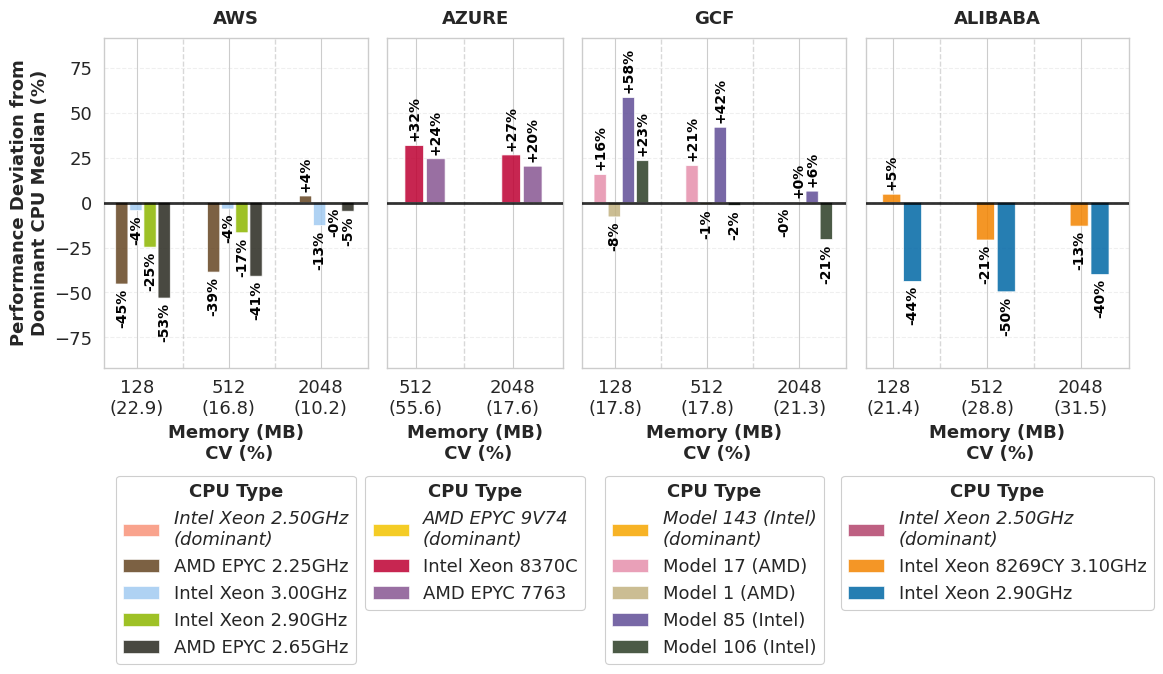

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_color
import seaborn as sns

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def plot_stage_b_deviation(
    df: pd.DataFrame,
    trimmed_df: pd.DataFrame,
    save_path: str | None = None,
    show: bool = True,
) -> plt.Figure:

    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]
    metric = metric_for_benchmark("gemm")

    fig, axes = plt.subplots(
        1, 4, figsize=(12, 5), sharey=True,
        gridspec_kw={"width_ratios": [3, 2, 3, 3]}
    )

    global_changes = []

    for idx, provider in enumerate(providers):
        ax = axes[idx]
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes

        trimmed_provider_df = trimmed_df[
            (trimmed_df["provider"] == provider) &
            (trimmed_df["benchmark_type"] == "gemm")
        ]
        
        provider_df = df[
            (df["provider"] == provider) &
            (df["benchmark_type"] == "gemm")
        ]
        

        provider_cpu_order = (
            trimmed_provider_df.groupby("cpu_type")["instance_id"]
            .nunique()
            .sort_values(ascending=False)
            .index
            .tolist()
        )
        dominant_CPU = provider_cpu_order[0]

        all_plot_data = {}
        config_cvs = {}

        for memory_size in provider_memory_sizes:
            config_df = trimmed_provider_df[trimmed_provider_df["memory_size_mb"] == memory_size]
            config_raw_df = provider_df[provider_df["memory_size_mb"] == memory_size]
            
            config_mean = config_df[metric].mean()
            config_std = config_df[metric].std()

            config_cvs[memory_size] = (config_std / config_mean) * 100

            cpu_medians = config_raw_df.groupby("cpu_type")[metric].median()
            dominant_CPU_median = cpu_medians.get(dominant_CPU, np.nan)
            
            pct_map = {
                cpu: (cpu_med - dominant_CPU_median) / dominant_CPU_median * 100.0
                for cpu, cpu_med in cpu_medians.items()
            }
            all_plot_data[memory_size] = pct_map

        bar_width = 0.6
        config_gap = 1.5
        current_x = 0.0

        config_centers = []
        bar_positions = []

        for memory_size in provider_memory_sizes:
            pct_map = all_plot_data.get(memory_size, {})
            cpus_in_config = [cpu for cpu in provider_cpu_order if cpu in pct_map and cpu != dominant_CPU]
            n_bars = len(cpus_in_config)
            config_start = current_x

            for bar_idx, cpu in enumerate(cpus_in_config):
                x_pos = config_start + bar_idx * bar_width
                bar_positions.append({
                    "x": x_pos,
                    "memory_size": memory_size,
                    "cpu": cpu,
                    "pct_change": float(pct_map[cpu]),
                })

            config_center = config_start + (n_bars - 1) * bar_width / 2
            config_centers.append(config_center)
            current_x = config_start + n_bars * bar_width + config_gap

        for bd in bar_positions:
            x_pos = bd["x"]
            pct_change = bd["pct_change"]
            cpu = bd["cpu"]
            color = get_cpu_color(cpu, provider=provider)
            bar_w = bar_width * 0.85

            if pct_change < 0:
                patch = FancyBboxPatch(
                    (x_pos, pct_change), bar_w, -pct_change,
                    boxstyle="round,pad=0.005",
                    edgecolor="white", facecolor=color,
                    linewidth=0.6, alpha=0.85
                )
            else:
                patch = FancyBboxPatch(
                    (x_pos, 0), bar_w, pct_change,
                    boxstyle="round,pad=0.005",
                    edgecolor="white", facecolor=color,
                    linewidth=0.6, alpha=0.85
                )
            ax.add_patch(patch)

            offset = 2.5
            label_y = pct_change + offset if pct_change >= 0 else pct_change - offset
            va = "bottom" if pct_change >= 0 else "top"

            ax.text(
                x_pos + bar_w / 2, label_y,
                f"{pct_change:+.0f}%",
                ha="center", va=va,
                fontsize=10, fontweight="bold", color="black",
                rotation=90, clip_on=False, zorder=20
            )
            global_changes.append(pct_change)

        for i in range(len(provider_memory_sizes) - 1):
            if i < len(config_centers) - 1:
                sep_x = (config_centers[i] + config_centers[i + 1]) / 2
                ax.axvline(sep_x, color="gray", linestyle="--", 
                          linewidth=1, alpha=0.3, zorder=1)

        ax.axhline(0, color="black", linestyle="-", linewidth=2, alpha=0.8, zorder=10)

        if idx == 0:
            ax.set_ylabel("Performance Deviation from\nDominant CPU Median (%)",
                         fontweight="bold", fontsize=13)

        # X-axis: Memory labels with CV annotation
        x_labels = []
        for mem, cv in zip(provider_memory_sizes, 
                          [config_cvs.get(m) for m in provider_memory_sizes]):
            if cv is not None:
                x_labels.append(f"{mem}\n({cv:.1f})")
            else:
                x_labels.append(f"{mem}")

        ax.set_xticks(config_centers)
        ax.set_xticklabels(x_labels, fontsize=13)
        ax.set_xlabel("Memory (MB)\n CV (%)", fontweight="bold", fontsize=13)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3, zorder=0)
        ax.tick_params(axis="both", which="major", labelsize=13)
    


        if bar_positions:
            ax.set_xlim(-0.5, max(b["x"] for b in bar_positions) + bar_width + 0.5)

        legend_handles = [
            Rectangle((0, 0), 1, 1, facecolor=get_cpu_color(cpu, provider), 
                      edgecolor="white", linewidth=0.5, alpha=0.85)
            for cpu in provider_cpu_order
        ]
        legend_labels = [shorten_cpu_name(cpu) for cpu in provider_cpu_order]

        if provider == "gcp":
            provider ="gcf"
        ax.set_title(provider.upper(), fontweight="bold", fontsize=13, pad=10)

        dominant_cpu_index = provider_cpu_order.index(dominant_CPU)
        legend_labels[dominant_cpu_index] += "\n(dominant)"

        leg = ax.legend(
            legend_handles, legend_labels,
            loc="upper center", bbox_to_anchor=(0.5, -0.3),
            framealpha=0.95, fontsize=13, ncol=1,
            title="CPU Type", title_fontsize=13
        )

        for txt in leg.get_texts():
            if "(dominant)" in txt.get_text():
                txt.set_fontstyle("italic") 

        leg.get_title().set_fontweight("bold")

    if global_changes:
        max_abs = max(abs(min(global_changes)), abs(max(global_changes)))
        pad = 10
        for ax in axes:
            ax.set_ylim(-(max_abs * 1.4 + pad), (max_abs * 1.4 + pad))


    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.24, wspace=0.08)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"Saved: {save_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig

# === Usage ===
fig = plot_stage_b_deviation(
    df=df,
    trimmed_df=trimmed_df,
    save_path="plots/stage_b/deviation_from_median.pdf"
)

Saved: plots/stage_b/cv_heatmap.pdf


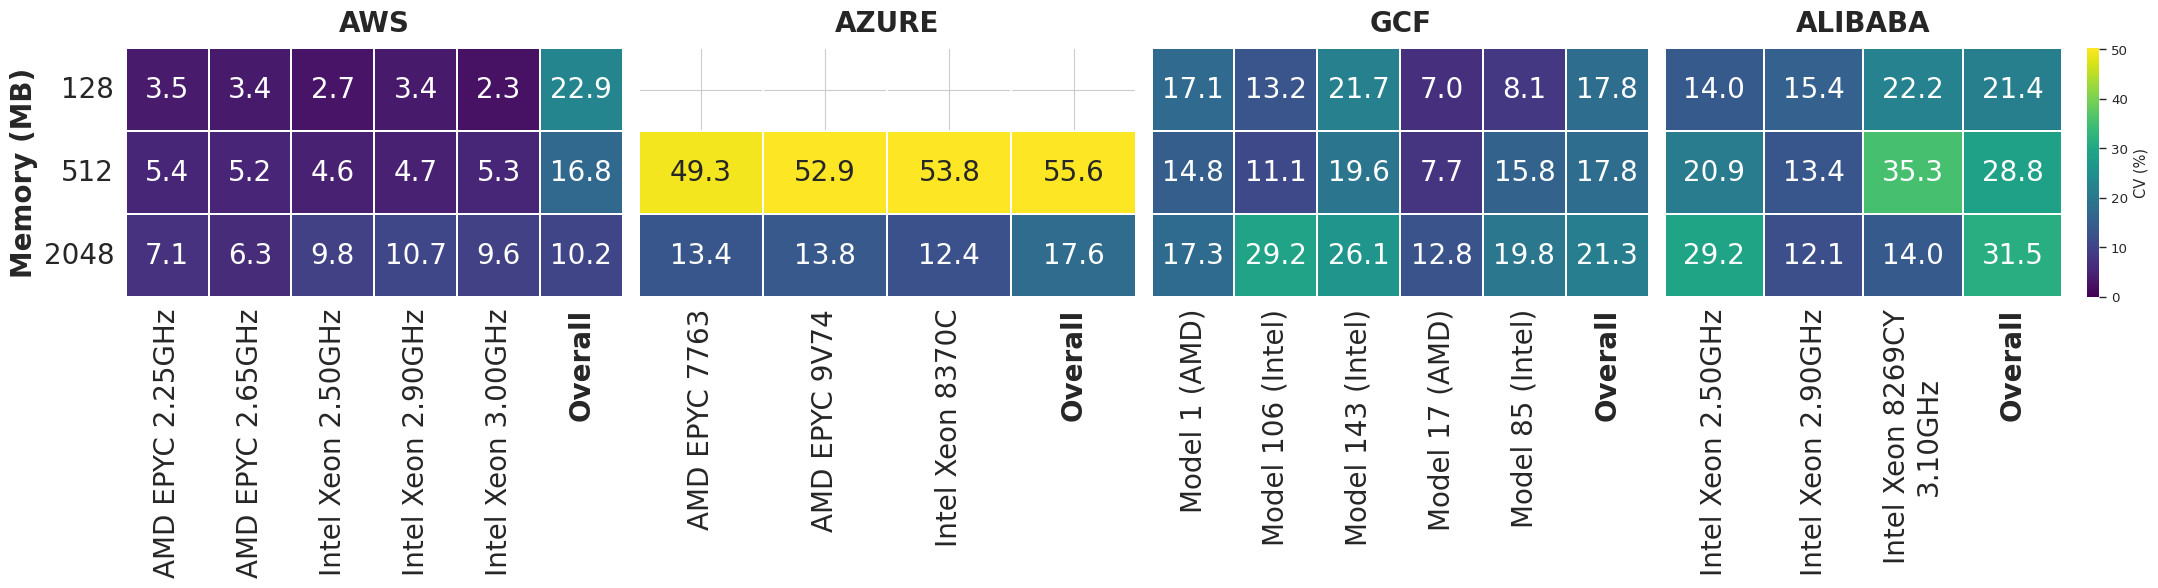

In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

from helpers.benchmark import metric_for_benchmark


sns.set_theme(style="whitegrid", context="paper", font_scale=1.1)


def plot_stage_b_cv_heatmap(
    trimmed_df: pd.DataFrame,
    save_path: str | None = None,
    show: bool = True,
    gamma_for_vmax: float = 0.95,
) -> plt.Figure:
    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]
    metric = metric_for_benchmark("gemm")

    cpu_stats = trimmed_df.groupby(["provider", "memory_size_mb", "cpu_type"])[metric].agg(['mean', 'std']).reset_index()
    cpu_stats['cv'] = (cpu_stats['std'] / cpu_stats['mean']) * 100

    overall_stats = trimmed_df.groupby(["provider", "memory_size_mb"])[metric].agg(['mean', 'std']).reset_index()
    overall_stats["cv"] = (overall_stats["std"] / overall_stats["mean"]) * 100.0

    cpu_stats["cv"] = cpu_stats["cv"].replace([np.inf, -np.inf], np.nan)
    overall_stats["cv"] = overall_stats["cv"].replace([np.inf, -np.inf], np.nan)

    all_cv = pd.concat([cpu_stats["cv"], overall_stats["cv"]], ignore_index=True)
    all_cv = all_cv[np.isfinite(all_cv.to_numpy())]

    if len(all_cv):
        vmax = float(np.nanpercentile(all_cv, gamma_for_vmax * 100.0))
        vmax = max(vmax, 1.0)
    else:
        vmax = 1.0

    vmin = 0.0

    # ---- Plot ----
    fig, axes = plt.subplots(1, 4, figsize=(5.5 * 4, 6), sharey=True)

    for i, provider in enumerate(providers):
        ax = axes[i]

        sub_cpu = cpu_stats[cpu_stats["provider"] == provider]
        sub_overall = overall_stats[overall_stats["provider"] == provider]

        pivot = (
            sub_cpu
            .pivot_table(index="memory_size_mb", columns="cpu_type", values="cv", aggfunc="mean")
            .reindex(index=memory_sizes)
        )

        overall_series = sub_overall.set_index("memory_size_mb")["cv"].reindex(memory_sizes)
        pivot["Overall"] = overall_series

        wrap = lambda s: "\n".join(textwrap.wrap(s, width=20))
        pivot.columns = [wrap(str(c)) for c in pivot.columns]



        cols = [c for c in pivot.columns if c != "Overall"] + ["Overall"] 
        pivot = pivot[cols]

        sns.heatmap(
            pivot,
            ax=ax,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=".1f",
            linewidths=0.3,
            linecolor="white",
            cbar=(i == 3),
            cbar_kws={"label": "CV (%)"},
            annot_kws={"fontsize": 20},
        )

        for t in ax.get_xticklabels():
            if t.get_text() == "Overall":
                t.set_fontweight("bold")

        if provider == "gcp":
            provider ="gcf"
        ax.set_title(provider.upper(), fontweight="bold", fontsize=20, pad=12)
        ax.set_ylabel("Memory (MB)" if i == 0 else "", fontweight="bold", fontsize=20)
        ax.tick_params(axis="x", rotation=90, labelsize=20)
        ax.tick_params(axis="y", rotation=0, labelsize=20)


    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"Saved: {save_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig


fig = plot_stage_b_cv_heatmap(
    trimmed_df,
    save_path="plots/stage_b/cv_heatmap.pdf",
)
